# Imports

In [1]:
import pysweep
import qcodes as qc
import pysweep.databackends.debug
import pysweep.databackends.list_backend
import pysweep.databackends.qcodes
import pysweep.core.measurementfunctions
from pysweep.core.sweepobject import SweepObject
from pysweep.core.measurementfunctions import MakeMeasurementFunction
import pysweep.convenience as conv
import random
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [15]:
from pysweep.databackends.base import DataParameter
from pytopo.qctools.dataset2 import select_experiment
from qcodes.dataset.measurements import Measurement

from qcodes import load_by_id
import qcodes as qc
import qcodes.dataset.plotting
import importlib

In [3]:
station = qc.Station()
pysweep.STATION = station
qc.config.core.db_location = r'D:\OneDrive\BF1\Code\pysweep\testdata.db'
qc.initialise_database()

# Define a few parameters with physics

In [4]:
bias = qc.instrument.parameter.ManualParameter("bias", units="V")
T1 = qc.instrument.parameter.ManualParameter("T1", units="V")
T2 = qc.instrument.parameter.ManualParameter("T2", units="V")

bias(0)
T1(0)
T2(0)

def pinchoff(v, rs=10e3, l=2e-6, muc=3*60e-18, vth=-1):
    if v>vth:
        return (rs+l**2/(muc*(v-vth)))
    else:
        return 1e11

def get_current():
    u = bias()
    r = pinchoff(T1())+pinchoff(T2())
    return u/r
current = qc.instrument.parameter.Parameter("current", units="A", get_cmd=get_current)



# Define the functions that define the measurement

We need to define what happens at the start of a measurement, what must happen at the end of a measurement and finally what a measurement entails

In [5]:
def init_measurement(d):
    bias(1e-3)

def end_measurement(d):
    bias(0)

In [6]:
@MakeMeasurementFunction([['current', 'A']])
def measure(d):
    return [current()]

lets also define a function the measures the hypothetical temperature of our fridge

In [7]:
@MakeMeasurementFunction([['Temperature', 'mK']])
def measure_temperature(d):
    return [random.randint(100, 300)/10]

# Simple measurements

This paragraph contains some measurements that corresponds to the easiest cases of measurements. The cases cover 90% of all measurements that will run, but don't show the full power of pysweep

In [8]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)
r = pysweep.sweep(init_measurement, end_measurement, measure, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
None2 , postponing registration
Starting experimental run with id: 13


([<matplotlib.axes._subplots.AxesSubplot at 0x1763ac4f708>], [None])

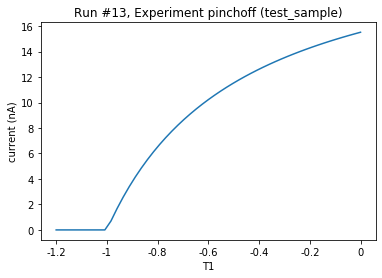

In [18]:
qcodes.dataset.plotting.plot_by_id(r.datasaver.run_id)

In [19]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)
r = pysweep.sweep(init_measurement, end_measurement, measure, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 14


([<matplotlib.axes._subplots.AxesSubplot at 0x1763b63bf08>],
 [<matplotlib.colorbar.Colorbar at 0x1763b683588>])

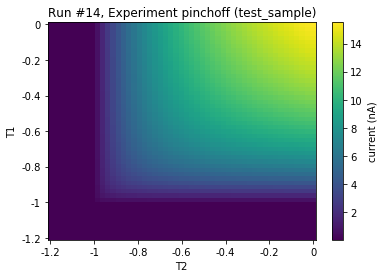

In [20]:
qcodes.dataset.plotting.plot_by_id(r.datasaver.run_id)

# Extended examples

Here are a few examples of measurements that are still relatively simples, but with a few more bells and whistles

Say that we want to measure the fridge temperature in addition to the current, then we simply execute

In [23]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)
r = pysweep.sweep(init_measurement, end_measurement, measure+measure_temperature, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 16


([<matplotlib.axes._subplots.AxesSubplot at 0x1763b6b3388>,
  <matplotlib.colorbar.Colorbar at 0x1763b3d4988>])

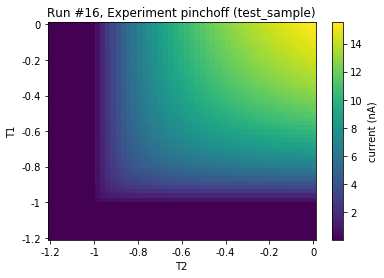

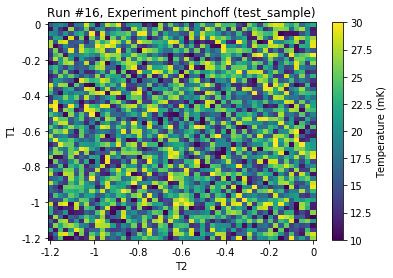

In [24]:
qcodes.dataset.plotting.plot_by_id(r.datasaver.run_id)

But often we only want to measure temperature every now and then, so let's assume that we want to measure the fridge tmeperature only after every time we set the T2 parameter

In [21]:
exp = select_experiment('pinchoff', 'test_sample')
meas = Measurement(exp, station)
r = pysweep.sweep(init_measurement, end_measurement, measure, 
              pysweep.sweep_object(T1, np.linspace(0,-1.2,51)), 
              conv.add_function(pysweep.sweep_object(T2, np.linspace(0,-1.2,51)), measure_temperature), 
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
            )

None3 , postponing registration
Starting experimental run with id: 15


([<matplotlib.axes._subplots.AxesSubplot at 0x1763baf7c88>,
 [None, <matplotlib.colorbar.Colorbar at 0x1763bbbfb08>])

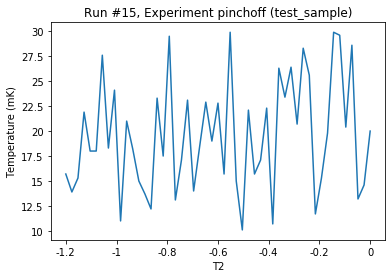

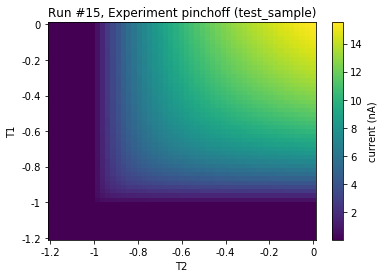

In [22]:
qcodes.dataset.plotting.plot_by_id(r.datasaver.run_id)

# Adaptive sweep - under construction

In [ ]:
@MakeMeasurementFunction([['timestamp', 's']])
def smart_point_function(dict_waterfall):
    timestamp = int(time.time())
    points = [int(c) for c in str(timestamp)]
    return points, [timestamp]

In [ ]:
db = pysweep.databackends.debug.DebugDataBackend()
pysweep.sweep(lambda d:{}, lambda d:{}, measure, 
              pysweep.sweep_object(a, [0,1]),
              conv.add_function(pysweep.sweep_object(b, [3,4]), measure_temperature),
              pysweep.sweep_object(c, smart_point_function, dataparameter=np.linspace(0,9,10)), databackend=db
             )

# Real life example - under construction

In [ ]:
%%enqueue single_shot_readout
exp = select_experiment('blobs', SAMPLE)
meas = Measurement(exp, station)
singleshot_dataextractor.setup_acquisition(1024, 1000, 100)
#4.77946e9
parameter_list = [[station.TI.NW_bias, 0e-3], [station.HT.frequency, 4779770000], [station.HT.RF.power, -20.25]]

pysweep.sweep(sf.set_parameters_after(init_rf, parameter_list), end_rf, 
              measure_singleshot_rf,
              pysweep.sweep_object(station.TI.SP4, snr_calibrate_plunger(pysweep.sweep_object(station.TI.SP4, np.linspace(0., 0.4, 101))), dataparameter=[0,1]),
              pysweep.convenience.add_function(pysweep.sweep_object(station.TI.T5, np.linspace(-1, -1.35, 101)), csc),
              databackend = pysweep.databackends.qcodes.DataBackend(meas)
             )
rigol.ch1_output_enabled(False)

# Jagged Data Structures - under construction

In [19]:
?DataParameter

In [20]:
@MakeMeasurementFunction([DataParameter('time', 's', 'array', 2),
                         DataParameter('first_gate', 'V', 'array', 2),
                         DataParameter('second_gate', 'V', 'array', 2),
                         DataParameter('first_gate_result', 'I', 'array', extra_dependencies=['time', 'first_gate']),
                         DataParameter('time', 's', 'array', 2, duplicate=True),
                         DataParameter('second_gate_result', 'I', 'array', extra_dependencies=['time', 'second_gate'])])
def some_arbitrary_data(d):
    return [np.linspace(0,1, 11), np.linspace(0,0.1, 11), np.linspace(0,-0.1, 21), np.linspace(0,0.2, 11), np.linspace(1,2, 21), np.linspace(0,-0.2, 21)]

In [27]:
importlib.reload(pysweep.databackends.qcodes)

<module 'pysweep.databackends.qcodes' from 'd:\\onedrive\\bf1\\code\\pysweep\\pysweep\\databackends\\qcodes.py'>

In [30]:
exp = select_experiment('jagged_data', 'test')
meas = Measurement(exp, station)

pysweep.sweep(init_measurement, end_measurement, 
              some_arbitrary_data,
              pysweep.sweep_object(T1, np.linspace(0,1,2)),
              databackend = pysweep.databackends.qcodes.CutDataBackend(meas)
             )

None3 , postponing registration
None2 , postponing registration
[True, True, True, 2, 2, 2, False, 2, False]
Starting experimental run with id: 12
{'first_gate_result': ['T1', 'time', 'first_gate'], 'second_gate_result': ['T1', 'time', 'second_gate']}
{'first_gate_result': ['T1', 'time', 'first_gate'], 'second_gate_result': ['T1', 'time', 'second_gate']}


In [36]:
raw_data = load_by_id(12)
data = raw_data.get_parameter_data()

In [34]:
raw_data

results #12@D:\OneDrive\BF1\Code\pysweep\testdata.db
----------------------------------------------------
T1 - numeric
time - array
first_gate - array
second_gate - array
first_gate_result - array
second_gate_result - array

In [38]:
data['first_gate_result']['first_gate_result']

array([[0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ],
       [0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]])

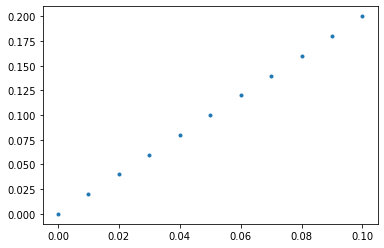

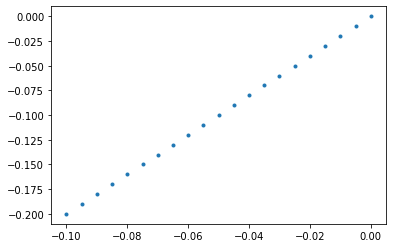

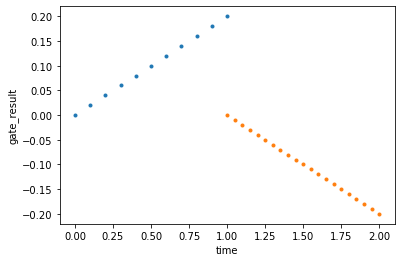

In [45]:
plt.plot(data['first_gate_result']['first_gate'][0], data['first_gate_result']['first_gate_result'][0], '.')
plt.show()
plt.plot(data['second_gate_result']['second_gate'][0], data['second_gate_result']['second_gate_result'][0], '.')
plt.show()
plt.plot(data['first_gate_result']['time'][0], data['first_gate_result']['first_gate_result'][0], '.')
plt.plot(data['second_gate_result']['time'][0], data['second_gate_result']['second_gate_result'][0], '.')
plt.xlabel('time')
plt.ylabel('gate_result')
plt.show()

In [5]:
from plottr.data.datadict import datadict_to_meshgrid
from plottr.data.qcodes_dataset import ds_to_datadict

In [ ]:
def load(runid):
    return datadict_to_meshgrid(ds_to_datadict(load_by_id(runid)))

In [8]:
ds = ds_to_datadict(load_by_id(12))

In [50]:
from plottr.node.data_selector import DataSelector

In [ ]:
dataselector = DataSelector('dataselector')

In [10]:
ds

{'first_gate_result': {'unit': 'I',
  'axes': ['T1', 'time', 'first_gate'],
  'values': array([[0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ],
         [0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]])},
 'T1': {'unit': '',
  'values': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
  'axes': []},
 'time': {'unit': 's',
  'values': array([[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
         [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]]),
  'axes': []},
 'first_gate': {'unit': 'V',
  'values': array([[0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ],
         [0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]]),
  'axes': []},
 'T1_0': {'unit': '',
  'values': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [12]:
ds2 = ds.extract(['first_gate_result'])

In [15]:
ds3 = datadict_to_meshgrid(ds2)
ds3.validate()

True

In [19]:
ds3.shape()

(2, 11, 1)

In [23]:
ds3.structure(), ds3.shapes()

({'first_gate_result': {'unit': 'I', 'axes': ['T1', 'time', 'first_gate']},
  'T1': {'unit': '', 'axes': []},
  'time': {'unit': 's', 'axes': []},
  'first_gate': {'unit': 'V', 'axes': []}},
 {'first_gate_result': (2, 11, 1),
  'T1': (2, 11, 1),
  'time': (2, 11, 1),
  'first_gate': (2, 11, 1)})

In [24]:
ds3.sanitize()

{'first_gate_result': {'unit': 'I',
  'axes': ['T1', 'time', 'first_gate'],
  'values': array([[[0.  ],
          [0.02],
          [0.04],
          [0.06],
          [0.08],
          [0.1 ],
          [0.12],
          [0.14],
          [0.16],
          [0.18],
          [0.2 ]],
  
         [[0.  ],
          [0.02],
          [0.04],
          [0.06],
          [0.08],
          [0.1 ],
          [0.12],
          [0.14],
          [0.16],
          [0.18],
          [0.2 ]]])},
 'T1': {'unit': '', 'axes': [], 'values': array([[[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],
  
         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]]])},
 'time': {'unit': 's', 'axes': [], 'values': array([[[0. ],
          [0.1],
          [0.2],
          [0.3],